In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import simulators.cosmic_shear.cosmic_shear as cosmic_shear
import ndes.nde as nde
import distributions.priors as priors
import compression.IMNN.IMNN_delfi as IMNN

In [3]:
### SET UP FOR SIMULATION CODE ###

# n(z)
nz = 10
pz = np.loadtxt('simulators/cosmic_shear/pz.dat')
z = pz[0,:]
pz_fid = [0]*nz
for i in range(1, nz+1):
    pz_fid[i-1] = interpolate.InterpolatedUnivariateSpline(z, pz[i,:])

# Set up fiducial parameters and binning
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
nz = 10
npar = 5
n_data = 5

# Define the priors
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior_mean = theta_fiducial
sigmas = np.zeros(npar)
sigmas[0:5] = np.array([0.1, 0.1, 0.05, 0.3, 0.3])
Q = np.eye(npar)*sigmas**2
Qinv = np.linalg.inv(Q)
prior_args = [prior_mean, Q, lower, upper]

# Parameter names and ranges for plotting  
names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s']
labels =  ['\\Omega_m', 'S_8', '\\Omega_b', 'h', 'n_s']
ranges = {'\Omega_m':[lower[0], upper[0]], 'S_8':[lower[1],upper[1]],'\Omega_b':[lower[2],upper[2]],
            'h':[lower[3],upper[3]],'n_s':[lower[4],upper[4]]}

# Scale binning
lmax = 3000
lmin = 10
modes_edges = np.logspace(np.log10(lmin), np.log10(lmax), 11)
modes = (modes_edges[0:-1] + modes_edges[1:])/2
l = np.arange(lmin, lmax)
nl = np.array([sum((2*l[(l >= modes_edges[i])*(l < modes_edges[i+1])] + 1)) for i in range(len(modes))], dtype=int)

# Number of effective modes
A_sky = 15000*(np.pi/180)**2
f_sky = A_sky/(4*np.pi)
nl = np.array(nl*f_sky, dtype=int)

# Noise covariance
sigma_e = 0.3
nbar = 3*(60*180./np.pi)**2
N = (sigma_e**2/nbar)*np.eye(nz)

# Fiducial power spectrum
C = cosmic_shear.power_spectrum(theta_fiducial, pz_fid, modes, N)
Cinv = np.array([np.linalg.inv(C[:,:,l]) for l in range(len(modes))]).T

# Derivative of power spectrum
h = np.array(abs(theta_fiducial[0:5])*np.array([0.05, 0.05, 0.05, 0.05, 0.05]))
dCdt = np.zeros((npar, nz, nz, len(modes)))

# Derivatives wrt cosmological parameters
for i in range(npar):
    theta_plus = np.copy(theta_fiducial)
    theta_plus[i] += h[i]
    theta_minus = np.copy(theta_fiducial)
    theta_minus[i] -= h[i]
    
    Cp = cosmic_shear.power_spectrum(theta_plus, pz_fid, modes, np.zeros((nz, nz)))
    Cm = cosmic_shear.power_spectrum(theta_minus, pz_fid, modes, np.zeros((nz, nz)))
    C0 = cosmic_shear.power_spectrum(theta_fiducial, pz_fid, modes, np.zeros((nz, nz)))

    dCdt[i, :, :, :] = (Cp - Cm)/(2*h[i])

# Fisher matrix
F, Finv, fisher_errors = cosmic_shear.fisher_matrix(Cinv, dCdt, npar, nl, Qinv)

In [4]:
# Define the simulator function: takes parameters, spits out simulated data
# Should have the form: simulator(parameters, args) -> simulated dataset
simulator = cosmic_shear.simulate
simulator_args = [pz_fid, modes, N, nl]

In [5]:
# Create prior over parameters
prior = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

In [ ]:
## Define the compression function: takes data, spits out compressed summaries
## Should have the form compressor(data, args) -> compressed summaries
## NB: compression should be set-up like a quasi maximum-likelihood estimator
der = np.array([0.05, 0.05, 0.05, 0.05, 0.05])
initial_sims = 1000
n_epochs = 100
n = IMNN.get_network(simulator, simulator_args, theta_fiducial, der, initial_sims, "cosmic_shear", make_simulations = True)

Derivative simulations:   0%|          | 0/100 [00:00<?, ?it/s]

[0.25 0.8  0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.35 0.8  0.05 0.7  0.96]
[0.25 0.8  0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.35 0.8  0.05 0.7  0.96]
[0.25 0.8  0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.35 0.8  0.05 0.7  0.96]
[0.25 0.8  0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.35 0.8  0.05 0.7  0.96]
[0.25 0.8  0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.35 0.8  0.05 0.7  0.96]
[0.25 0.8  0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.35 0.8  0.05 0.7  0.96]
[0.25 0.8  0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.35 0.8  0.05 0.7  0.96]
[0.25 0.8  0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.35 0.8  0.05 0.7  0.96]
[0.25 0.8  0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.35 0.8  0.05 0.7  0.96]
[0.25 0.8  0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.35 0.8  0.05 0.7  0.96]
[0.25 0.8  0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.35 0.8  0.05 0.7  0.96]
[0.25 0.8  0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.35 0.8  0.05 0.7  0.96]
[0.25 0.8  0.05 0.7  0.96] [

/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \
/hdd/delfi/simulators/cosmic_shear/cosmology.py:195: RuntimeWarning: invalid value encountered in double_scalars
  (1.0 + sqrt(self._R_eq)))
/hdd/delfi/simulators/cosmic_shear/cosmology.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  g1 = 0.078*w_b**(-0.238) * (1.0 + 39.5*w_b**0.7630)**(-1)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:208: RuntimeWarning: divide by zero encountered in double_scalars
  a_r = 1.0/(1048.*(1.0+0.00124*w_b**(-0.738))*(1.0+g1*w_m**g2) + 1)
/hdd/delfi/simulators/cosmic_shear/utils.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  return 1.0/a - 1.0
/hdd/delfi/simulators/cosmic_shear/cosmology.py:217: RuntimeWarning: divide by zero encountered in double_scalars
  log(frac) * self.h  # Eq. (19) converted to Mpc/h
/hdd/delfi/simulators/cosmic_

[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \
/hdd/delfi/simulators/cosmic_shear/cosmology.py:195: RuntimeWarning: invalid value encountered in double_scalars
  (1.0 + sqrt(self._R_eq)))
/hdd/delfi/simulators/cosmic_shear/cosmology.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  g1 = 0.078*w_b**(-0.238) * (1.0 + 39.5*w_b**0.7630)**(-1)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:208: RuntimeWarning: divide by zero encountered in double_scalars
  a_r = 1.0/(1048.*(1.0+0.00124*w_b**(-0.738))*(1.0+g1*w_m**g2) + 1)
/hdd/delfi/simulators/cosmic_shear/utils.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  return 1.0/a - 1.0
/hdd/delfi/simulators/cosmic_shear/cosmology.py:217: RuntimeWarning: divide by zero encountered in double_scalars
  log(frac) * self.h  # Eq. (19) converted to Mpc/h
/hdd/delfi/simulators/cosmic_

[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \
/hdd/delfi/simulators/cosmic_shear/cosmology.py:195: RuntimeWarning: invalid value encountered in double_scalars
  (1.0 + sqrt(self._R_eq)))
/hdd/delfi/simulators/cosmic_shear/cosmology.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  g1 = 0.078*w_b**(-0.238) * (1.0 + 39.5*w_b**0.7630)**(-1)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:208: RuntimeWarning: divide by zero encountered in double_scalars
  a_r = 1.0/(1048.*(1.0+0.00124*w_b**(-0.738))*(1.0+g1*w_m**g2) + 1)
/hdd/delfi/simulators/cosmic_shear/utils.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  return 1.0/a - 1.0
/hdd/delfi/simulators/cosmic_shear/cosmology.py:217: RuntimeWarning: divide by zero encountered in double_scalars
  log(frac) * self.h  # Eq. (19) converted to Mpc/h
/hdd/delfi/simulators/cosmic_

[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \
/hdd/delfi/simulators/cosmic_shear/cosmology.py:195: RuntimeWarning: invalid value encountered in double_scalars
  (1.0 + sqrt(self._R_eq)))
/hdd/delfi/simulators/cosmic_shear/cosmology.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  g1 = 0.078*w_b**(-0.238) * (1.0 + 39.5*w_b**0.7630)**(-1)


[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/cosmology.py:672: RuntimeWarning: divide by zero encountered in true_divide
  exp(-pow(k / self._k_silk, 1.4))) * sinc(k*tilde_s/pi)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:208: RuntimeWarning: divide by zero encountered in double_scalars
  a_r = 1.0/(1048.*(1.0+0.00124*w_b**(-0.738))*(1.0+g1*w_m**g2) + 1)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:672: RuntimeWarning: divide by zero encountered in double_scalars
  exp(-pow(k / self._k_silk, 1.4))) * sinc(k*tilde_s/pi)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \
/hdd/delfi/simulators/cosmic_shear/utils.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  return 1.0/a - 1.0
/hdd/delfi/simulators/cosmic_shear/cosmology.py:217: RuntimeWarning: divide by zero encountered in double_scalars
  log(frac) * self.h  # Eq. (19) converted to Mpc/h
/hdd/

[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]
[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \
/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \


[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/cosmology.py:195: RuntimeWarning: invalid value encountered in double_scalars
  (1.0 + sqrt(self._R_eq)))
/hdd/delfi/simulators/cosmic_shear/cosmology.py:195: RuntimeWarning: invalid value encountered in double_scalars
  (1.0 + sqrt(self._R_eq)))
/hdd/delfi/simulators/cosmic_shear/cosmology.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  g1 = 0.078*w_b**(-0.238) * (1.0 + 39.5*w_b**0.7630)**(-1)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  g1 = 0.078*w_b**(-0.238) * (1.0 + 39.5*w_b**0.7630)**(-1)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \
/hdd/delfi/simulators/cosmic_shear/cosmology.py:208: RuntimeWarning: divide by zero encountered in double_scalars
  a_r = 1.0/(1048.*(1.0+0.00124*w_b**(-0.738))*(1.0+g1*w_m**g2) + 1)
/hdd/delfi

[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \
/hdd/delfi/simulators/cosmic_shear/cosmology.py:195: RuntimeWarning: invalid value encountered in double_scalars
  (1.0 + sqrt(self._R_eq)))
/hdd/delfi/simulators/cosmic_shear/cosmology.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  g1 = 0.078*w_b**(-0.238) * (1.0 + 39.5*w_b**0.7630)**(-1)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:208: RuntimeWarning: divide by zero encountered in double_scalars
  a_r = 1.0/(1048.*(1.0+0.00124*w_b**(-0.738))*(1.0+g1*w_m**g2) + 1)
/hdd/delfi/simulators/cosmic_shear/utils.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  return 1.0/a - 1.0
/hdd/delfi/simulators/cosmic_shear/cosmology.py:217: RuntimeWarning: divide by zero encountered in double_scalars
  log(frac) * self.h  # Eq. (19) converted to Mpc/h
/hdd/delfi/simulators/cosmic_

[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \


[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/cosmology.py:195: RuntimeWarning: invalid value encountered in double_scalars
  (1.0 + sqrt(self._R_eq)))
/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \
/hdd/delfi/simulators/cosmic_shear/cosmology.py:195: RuntimeWarning: invalid value encountered in double_scalars
  (1.0 + sqrt(self._R_eq)))
/hdd/delfi/simulators/cosmic_shear/cosmology.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  g1 = 0.078*w_b**(-0.238) * (1.0 + 39.5*w_b**0.7630)**(-1)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  g1 = 0.078*w_b**(-0.238) * (1.0 + 39.5*w_b**0.7630)**(-1)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:208: RuntimeWarning: divide by zero encountered in double_scalars
  a_r = 1.0/(1048.*(1.0+0.00124*w_b**(-0.738))*(1.0+g1*w_m**g2) + 1)
/hdd/delfi

[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \
/hdd/delfi/simulators/cosmic_shear/cosmology.py:195: RuntimeWarning: invalid value encountered in double_scalars
  (1.0 + sqrt(self._R_eq)))
/hdd/delfi/simulators/cosmic_shear/cosmology.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  g1 = 0.078*w_b**(-0.238) * (1.0 + 39.5*w_b**0.7630)**(-1)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:672: RuntimeWarning: divide by zero encountered in true_divide
  exp(-pow(k / self._k_silk, 1.4))) * sinc(k*tilde_s/pi)


[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/cosmology.py:672: RuntimeWarning: divide by zero encountered in double_scalars
  exp(-pow(k / self._k_silk, 1.4))) * sinc(k*tilde_s/pi)


[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/cosmology.py:208: RuntimeWarning: divide by zero encountered in double_scalars
  a_r = 1.0/(1048.*(1.0+0.00124*w_b**(-0.738))*(1.0+g1*w_m**g2) + 1)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \
/hdd/delfi/simulators/cosmic_shear/cosmology.py:195: RuntimeWarning: invalid value encountered in double_scalars
  (1.0 + sqrt(self._R_eq)))
/hdd/delfi/simulators/cosmic_shear/cosmology.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  g1 = 0.078*w_b**(-0.238) * (1.0 + 39.5*w_b**0.7630)**(-1)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:208: RuntimeWarning: divide by zero encountered in double_scalars
  a_r = 1.0/(1048.*(1.0+0.00124*w_b**(-0.738))*(1.0+g1*w_m**g2) + 1)
/hdd/delfi/simulators/cosmic_shear/utils.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  return 1.0/a - 1.0
/hdd/delfi/s

[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/cosmology.py:672: RuntimeWarning: divide by zero encountered in true_divide
  exp(-pow(k / self._k_silk, 1.4))) * sinc(k*tilde_s/pi)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:672: RuntimeWarning: divide by zero encountered in double_scalars
  exp(-pow(k / self._k_silk, 1.4))) * sinc(k*tilde_s/pi)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:217: RuntimeWarning: divide by zero encountered in double_scalars
  log(frac) * self.h  # Eq. (19) converted to Mpc/h
/hdd/delfi/simulators/cosmic_shear/cosmology.py:217: RuntimeWarning: invalid value encountered in double_scalars
  log(frac) * self.h  # Eq. (19) converted to Mpc/h
/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \
/hdd/delfi/simulators/cosmic_shear/cosmology.py:195: RuntimeWarning: invalid value encountered in double_scalars
  (1.0 + sqrt(self._R_eq)))


[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/cosmology.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  g1 = 0.078*w_b**(-0.238) * (1.0 + 39.5*w_b**0.7630)**(-1)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:672: RuntimeWarning: divide by zero encountered in true_divide
  exp(-pow(k / self._k_silk, 1.4))) * sinc(k*tilde_s/pi)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \
/hdd/delfi/simulators/cosmic_shear/cosmology.py:208: RuntimeWarning: divide by zero encountered in double_scalars
  a_r = 1.0/(1048.*(1.0+0.00124*w_b**(-0.738))*(1.0+g1*w_m**g2) + 1)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:672: RuntimeWarning: divide by zero encountered in double_scalars
  exp(-pow(k / self._k_silk, 1.4))) * sinc(k*tilde_s/pi)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:195: RuntimeWarning: invalid value encountered in double_scalars
  (1.0 + sqrt(

[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/cosmology.py:672: RuntimeWarning: divide by zero encountered in double_scalars
  exp(-pow(k / self._k_silk, 1.4))) * sinc(k*tilde_s/pi)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \
/hdd/delfi/simulators/cosmic_shear/cosmology.py:195: RuntimeWarning: invalid value encountered in double_scalars
  (1.0 + sqrt(self._R_eq)))
/hdd/delfi/simulators/cosmic_shear/cosmology.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  g1 = 0.078*w_b**(-0.238) * (1.0 + 39.5*w_b**0.7630)**(-1)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:208: RuntimeWarning: divide by zero encountered in double_scalars
  a_r = 1.0/(1048.*(1.0+0.00124*w_b**(-0.738))*(1.0+g1*w_m**g2) + 1)
/hdd/delfi/simulators/cosmic_shear/utils.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  return 1.0/a - 1.0
/hdd/delfi/simulators/co

[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \
/hdd/delfi/simulators/cosmic_shear/cosmology.py:195: RuntimeWarning: invalid value encountered in double_scalars
  (1.0 + sqrt(self._R_eq)))
/hdd/delfi/simulators/cosmic_shear/cosmology.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  g1 = 0.078*w_b**(-0.238) * (1.0 + 39.5*w_b**0.7630)**(-1)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:208: RuntimeWarning: divide by zero encountered in double_scalars
  a_r = 1.0/(1048.*(1.0+0.00124*w_b**(-0.738))*(1.0+g1*w_m**g2) + 1)
/hdd/delfi/simulators/cosmic_shear/utils.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  return 1.0/a - 1.0
/hdd/delfi/simulators/cosmic_shear/cosmology.py:217: RuntimeWarning: divide by zero encountered in double_scalars
  log(frac) * self.h  # Eq. (19) converted to Mpc/h
/hdd/delfi/simulators/cosmic_

[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \


[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/cosmology.py:195: RuntimeWarning: invalid value encountered in double_scalars
  (1.0 + sqrt(self._R_eq)))
/hdd/delfi/simulators/cosmic_shear/cosmology.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  g1 = 0.078*w_b**(-0.238) * (1.0 + 39.5*w_b**0.7630)**(-1)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \
/hdd/delfi/simulators/cosmic_shear/cosmology.py:208: RuntimeWarning: divide by zero encountered in double_scalars
  a_r = 1.0/(1048.*(1.0+0.00124*w_b**(-0.738))*(1.0+g1*w_m**g2) + 1)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:195: RuntimeWarning: invalid value encountered in double_scalars
  (1.0 + sqrt(self._R_eq)))
/hdd/delfi/simulators/cosmic_shear/utils.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  return 1.0/a - 1.0
/hdd/delfi/simulators/cosmic_shear/cosmology.py:206: R

[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/cosmology.py:672: RuntimeWarning: divide by zero encountered in true_divide
  exp(-pow(k / self._k_silk, 1.4))) * sinc(k*tilde_s/pi)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:672: RuntimeWarning: divide by zero encountered in true_divide
  exp(-pow(k / self._k_silk, 1.4))) * sinc(k*tilde_s/pi)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:672: RuntimeWarning: divide by zero encountered in double_scalars
  exp(-pow(k / self._k_silk, 1.4))) * sinc(k*tilde_s/pi)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \
/hdd/delfi/simulators/cosmic_shear/cosmology.py:672: RuntimeWarning: divide by zero encountered in double_scalars
  exp(-pow(k / self._k_silk, 1.4))) * sinc(k*tilde_s/pi)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:195: RuntimeWarning: invalid value encountered in double_scalars
  (1.0 + sqrt(self._R_eq)))


[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/cosmology.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  g1 = 0.078*w_b**(-0.238) * (1.0 + 39.5*w_b**0.7630)**(-1)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \
/hdd/delfi/simulators/cosmic_shear/cosmology.py:208: RuntimeWarning: divide by zero encountered in double_scalars
  a_r = 1.0/(1048.*(1.0+0.00124*w_b**(-0.738))*(1.0+g1*w_m**g2) + 1)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:195: RuntimeWarning: invalid value encountered in double_scalars
  (1.0 + sqrt(self._R_eq)))
/hdd/delfi/simulators/cosmic_shear/utils.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  return 1.0/a - 1.0
/hdd/delfi/simulators/cosmic_shear/cosmology.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  g1 = 0.078*w_b**(-0.238) * (1.0 + 39.5*w_b**0.7630)**(-1)
/hdd/delfi/simulators

[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \
/hdd/delfi/simulators/cosmic_shear/cosmology.py:195: RuntimeWarning: invalid value encountered in double_scalars
  (1.0 + sqrt(self._R_eq)))
/hdd/delfi/simulators/cosmic_shear/cosmology.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  g1 = 0.078*w_b**(-0.238) * (1.0 + 39.5*w_b**0.7630)**(-1)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:208: RuntimeWarning: divide by zero encountered in double_scalars
  a_r = 1.0/(1048.*(1.0+0.00124*w_b**(-0.738))*(1.0+g1*w_m**g2) + 1)
/hdd/delfi/simulators/cosmic_shear/utils.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  return 1.0/a - 1.0
/hdd/delfi/simulators/cosmic_shear/cosmology.py:217: RuntimeWarning: divide by zero encountered in double_scalars
  log(frac) * self.h  # Eq. (19) converted to Mpc/h
/hdd/delfi/simulators/cosmic_

[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]
[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \
/hdd/delfi/simulators/cosmic_shear/cosmology.py:195: RuntimeWarning: invalid value encountered in double_scalars
  (1.0 + sqrt(self._R_eq)))
/hdd/delfi/simulators/cosmic_shear/cosmology.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  g1 = 0.078*w_b**(-0.238) * (1.0 + 39.5*w_b**0.7630)**(-1)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:208: RuntimeWarning: divide by zero encountered in double_scalars
  a_r = 1.0/(1048.*(1.0+0.00124*w_b**(-0.738))*(1.0+g1*w_m**g2) + 1)
/hdd/delfi/simulators/cosmic_shear/utils.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  return 1.0/a - 1.0
/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \
/hdd/delfi/simulat

[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]
[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/cosmology.py:672: RuntimeWarning: divide by zero encountered in double_scalars
  exp(-pow(k / self._k_silk, 1.4))) * sinc(k*tilde_s/pi)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \
/hdd/delfi/simulators/cosmic_shear/cosmology.py:217: RuntimeWarning: divide by zero encountered in double_scalars
  log(frac) * self.h  # Eq. (19) converted to Mpc/h
/hdd/delfi/simulators/cosmic_shear/cosmology.py:217: RuntimeWarning: invalid value encountered in double_scalars
  log(frac) * self.h  # Eq. (19) converted to Mpc/h
/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \
/hdd/delfi/simulators/cosmic_shear/cosmology.py:195: RuntimeWarning: invalid value encountered in double_scalars
  (1.0 + sqrt(self._R_eq)))
/hd

[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/cosmology.py:208: RuntimeWarning: divide by zero encountered in double_scalars
  a_r = 1.0/(1048.*(1.0+0.00124*w_b**(-0.738))*(1.0+g1*w_m**g2) + 1)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:208: RuntimeWarning: divide by zero encountered in double_scalars
  a_r = 1.0/(1048.*(1.0+0.00124*w_b**(-0.738))*(1.0+g1*w_m**g2) + 1)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \
/hdd/delfi/simulators/cosmic_shear/utils.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  return 1.0/a - 1.0
/hdd/delfi/simulators/cosmic_shear/utils.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  return 1.0/a - 1.0
/hdd/delfi/simulators/cosmic_shear/cosmology.py:672: RuntimeWarning: divide by zero encountered in double_scalars
  exp(-pow(k / self._k_silk, 1.4))) * sinc(k*tilde_s/pi)
/hdd/delfi/simulators/cosm

[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/cosmology.py:217: RuntimeWarning: invalid value encountered in double_scalars
  log(frac) * self.h  # Eq. (19) converted to Mpc/h
/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \
/hdd/delfi/simulators/cosmic_shear/cosmology.py:195: RuntimeWarning: invalid value encountered in double_scalars
  (1.0 + sqrt(self._R_eq)))


[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/cosmology.py:672: RuntimeWarning: divide by zero encountered in true_divide
  exp(-pow(k / self._k_silk, 1.4))) * sinc(k*tilde_s/pi)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \
/hdd/delfi/simulators/cosmic_shear/cosmology.py:672: RuntimeWarning: divide by zero encountered in double_scalars
  exp(-pow(k / self._k_silk, 1.4))) * sinc(k*tilde_s/pi)


[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/cosmology.py:195: RuntimeWarning: invalid value encountered in double_scalars
  (1.0 + sqrt(self._R_eq)))
/hdd/delfi/simulators/cosmic_shear/cosmology.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  g1 = 0.078*w_b**(-0.238) * (1.0 + 39.5*w_b**0.7630)**(-1)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:208: RuntimeWarning: divide by zero encountered in double_scalars
  a_r = 1.0/(1048.*(1.0+0.00124*w_b**(-0.738))*(1.0+g1*w_m**g2) + 1)
/hdd/delfi/simulators/cosmic_shear/utils.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  return 1.0/a - 1.0
/hdd/delfi/simulators/cosmic_shear/cosmology.py:217: RuntimeWarning: divide by zero encountered in double_scalars
  log(frac) * self.h  # Eq. (19) converted to Mpc/h
/hdd/delfi/simulators/cosmic_shear/cosmology.py:217: RuntimeWarning: invalid value encountered in double_scalars
  log(frac) * self.h  # Eq. (19) converted to Mpc/h
/hdd/delfi/simulators/cosmic_shear/cosmol

[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \
/hdd/delfi/simulators/cosmic_shear/cosmology.py:217: RuntimeWarning: divide by zero encountered in double_scalars
  log(frac) * self.h  # Eq. (19) converted to Mpc/h


[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/cosmology.py:217: RuntimeWarning: invalid value encountered in double_scalars
  log(frac) * self.h  # Eq. (19) converted to Mpc/h
/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \
/hdd/delfi/simulators/cosmic_shear/cosmology.py:195: RuntimeWarning: invalid value encountered in double_scalars
  (1.0 + sqrt(self._R_eq)))
/hdd/delfi/simulators/cosmic_shear/cosmology.py:195: RuntimeWarning: invalid value encountered in double_scalars
  (1.0 + sqrt(self._R_eq)))


[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/cosmology.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  g1 = 0.078*w_b**(-0.238) * (1.0 + 39.5*w_b**0.7630)**(-1)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \


[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/cosmology.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  g1 = 0.078*w_b**(-0.238) * (1.0 + 39.5*w_b**0.7630)**(-1)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:208: RuntimeWarning: divide by zero encountered in double_scalars
  a_r = 1.0/(1048.*(1.0+0.00124*w_b**(-0.738))*(1.0+g1*w_m**g2) + 1)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:208: RuntimeWarning: divide by zero encountered in double_scalars
  a_r = 1.0/(1048.*(1.0+0.00124*w_b**(-0.738))*(1.0+g1*w_m**g2) + 1)
/hdd/delfi/simulators/cosmic_shear/utils.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  return 1.0/a - 1.0


[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/cosmology.py:195: RuntimeWarning: invalid value encountered in double_scalars
  (1.0 + sqrt(self._R_eq)))
/hdd/delfi/simulators/cosmic_shear/utils.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  return 1.0/a - 1.0
/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \
/hdd/delfi/simulators/cosmic_shear/cosmology.py:217: RuntimeWarning: divide by zero encountered in double_scalars
  log(frac) * self.h  # Eq. (19) converted to Mpc/h
/hdd/delfi/simulators/cosmic_shear/cosmology.py:672: RuntimeWarning: divide by zero encountered in true_divide
  exp(-pow(k / self._k_silk, 1.4))) * sinc(k*tilde_s/pi)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:217: RuntimeWarning: divide by zero encountered in double_scalars
  log(frac) * self.h  # Eq. (19) converted to Mpc/h
/hdd/delfi/simulators/cosmic_shear/cosmology.py:193:

[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/utils.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  return 1.0/a - 1.0
/hdd/delfi/simulators/cosmic_shear/cosmology.py:217: RuntimeWarning: divide by zero encountered in double_scalars
  log(frac) * self.h  # Eq. (19) converted to Mpc/h
/hdd/delfi/simulators/cosmic_shear/cosmology.py:672: RuntimeWarning: divide by zero encountered in double_scalars
  exp(-pow(k / self._k_silk, 1.4))) * sinc(k*tilde_s/pi)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:217: RuntimeWarning: invalid value encountered in double_scalars
  log(frac) * self.h  # Eq. (19) converted to Mpc/h
/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \
/hdd/delfi/simulators/cosmic_shear/cosmology.py:195: RuntimeWarning: invalid value encountered in double_scalars
  (1.0 + sqrt(self._R_eq)))
/hdd/delfi/simulators/cosmic_shear/cosmology.py:67

[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/utils.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  return 1.0/a - 1.0
/hdd/delfi/simulators/cosmic_shear/cosmology.py:672: RuntimeWarning: divide by zero encountered in true_divide
  exp(-pow(k / self._k_silk, 1.4))) * sinc(k*tilde_s/pi)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \
/hdd/delfi/simulators/cosmic_shear/cosmology.py:195: RuntimeWarning: invalid value encountered in double_scalars
  (1.0 + sqrt(self._R_eq)))
/hdd/delfi/simulators/cosmic_shear/cosmology.py:672: RuntimeWarning: divide by zero encountered in double_scalars
  exp(-pow(k / self._k_silk, 1.4))) * sinc(k*tilde_s/pi)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  g1 = 0.078*w_b**(-0.238) * (1.0 + 39.5*w_b**0.7630)**(-1)
/hdd/delfi/simulators/cosmic_shear/cosm

[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/cosmology.py:672: RuntimeWarning: divide by zero encountered in double_scalars
  exp(-pow(k / self._k_silk, 1.4))) * sinc(k*tilde_s/pi)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \
/hdd/delfi/simulators/cosmic_shear/cosmology.py:672: RuntimeWarning: divide by zero encountered in true_divide
  exp(-pow(k / self._k_silk, 1.4))) * sinc(k*tilde_s/pi)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:672: RuntimeWarning: divide by zero encountered in double_scalars
  exp(-pow(k / self._k_silk, 1.4))) * sinc(k*tilde_s/pi)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:672: RuntimeWarning: divide by zero encountered in true_divide
  exp(-pow(k / self._k_silk, 1.4))) * sinc(k*tilde_s/pi)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:195: RuntimeWarning: invalid value encountered in double_scalars
  (1.0 + sqrt(self._R_eq)))
/hdd

[0.3  0.75 0.05 0.7  0.96] [0.3  0.8  0.05 0.7  0.96] [0.3  0.85 0.05 0.7  0.96]


/hdd/delfi/simulators/cosmic_shear/cosmology.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  self._sh_d = 2.0/(3.0*self._k_eq) * sqrt(6.0/self._R_eq) * \
/hdd/delfi/simulators/cosmic_shear/cosmology.py:195: RuntimeWarning: invalid value encountered in double_scalars
  (1.0 + sqrt(self._R_eq)))
/hdd/delfi/simulators/cosmic_shear/cosmology.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  g1 = 0.078*w_b**(-0.238) * (1.0 + 39.5*w_b**0.7630)**(-1)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:208: RuntimeWarning: divide by zero encountered in double_scalars
  a_r = 1.0/(1048.*(1.0+0.00124*w_b**(-0.738))*(1.0+g1*w_m**g2) + 1)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:672: RuntimeWarning: divide by zero encountered in true_divide
  exp(-pow(k / self._k_silk, 1.4))) * sinc(k*tilde_s/pi)
/hdd/delfi/simulators/cosmic_shear/cosmology.py:672: RuntimeWarning: divide by zero encountered in double_scalars
  exp(-pow(k / self._k_silk, 1.4))) * sinc(

In [ ]:
IMNN.train_IMNN(n, n_epochs)

In [7]:
compressor = IMNN.IMNN_compressor
compressor_args = n

In [8]:
print("Target det(F) = ", np.linalg.det(F))
print("IMNN det(F) = ", n.history["det(test F)"][-1])

Target log(det(F)) =  4.277631554866884e+22
IMNN log(det(F)) =  7.7409616e+20


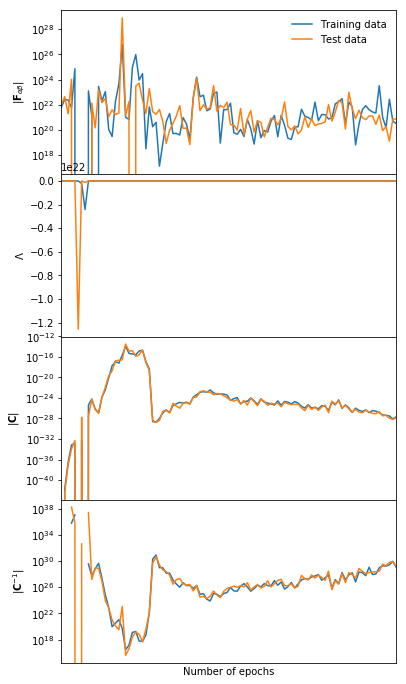

In [9]:
fig, ax = plt.subplots(4, 1, sharex = True, figsize = (6, 12))
plt.subplots_adjust(hspace = 0)
end = len(n.history["det(test F)"])
epochs = np.arange(1, end + 1)
a, = ax[0].plot(epochs, n.history["det(F)"][:end], label = 'Training data')
b, = ax[0].plot(epochs, n.history["det(test F)"][:end], label = 'Test data')
ax[0].set_yscale('log')
ax[0].legend(frameon = False)
ax[0].set_ylabel(r'$|{\bf F}_{\alpha\beta}|$')
ax[0].set_xticks([])
ax[1].plot(epochs, n.history["Λ"][:end])
ax[1].plot(epochs, n.history["test Λ"][:end])
ax[1].set_xlabel('Number of epochs')
ax[1].set_ylabel(r'$\Lambda$')
ax[1].set_xlim([1, len(epochs)]);
ax[2].plot(epochs, n.history["det(C)"])
ax[2].plot(epochs, n.history["det(test C)"])
ax[2].set_yscale('log')
ax[2].set_xlabel('Number of epochs')
ax[2].set_ylabel(r'$|{\bf C}|$')
ax[2].set_xlim([1, len(epochs)]);
ax[3].plot(epochs, n.history["det(iC)"])
ax[3].plot(epochs, n.history["det(test iC)"])
ax[3].set_xlabel('Number of epochs')
ax[3].set_ylabel(r'$|{\bf C}^{-1}|$')
ax[3].set_yscale('log')
ax[3].set_xlim([1, len(epochs)]);

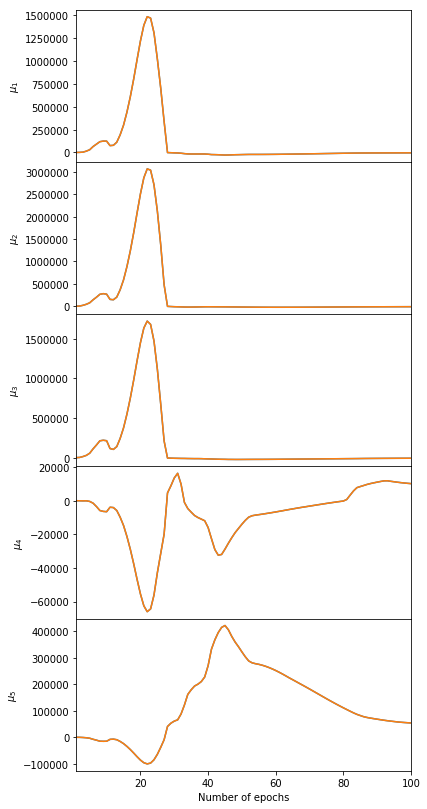

In [10]:
fig, ax = plt.subplots(5, 1, figsize = (6, 14))
plt.subplots_adjust(hspace = 0)
for i in range(5):
    ax[i].plot(epochs, np.array(n.history['μ'])[:, i])
    ax[i].plot(epochs, np.array(n.history['test μ'])[:, i])
    ax[i].set_ylabel("$\mu_{" + str(i + 1) + "}$")
    ax[i].set_xlim([1, len(epochs)])
    if i < 4:
        ax[i].set_xticks([])
    else:
        ax[i].set_xlabel('Number of epochs')

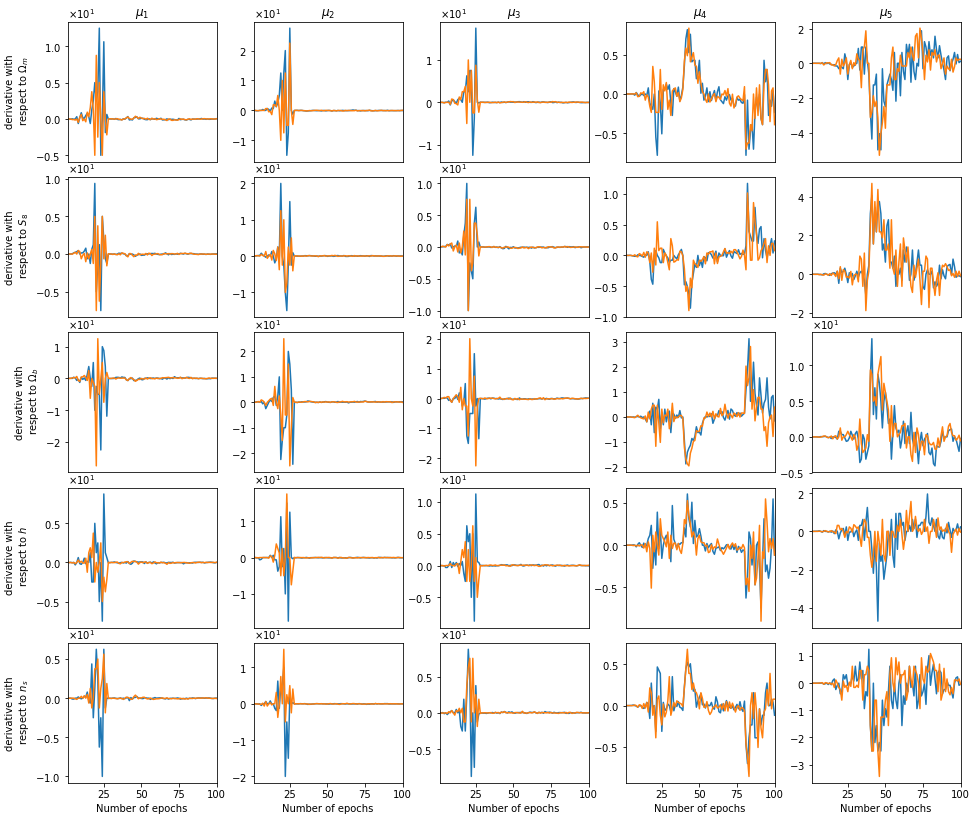

In [11]:
fig, ax = plt.subplots(5, 5, figsize = (16, 14))
plt.subplots_adjust(hspace = 0.11, wspace = 0.25)
plot_labels = ["$\Omega_m$", "$S_8$", "$\Omega_b$", "$h$", "$n_s$"]
for i in range(5):
    for j in range(5):
        ax[i, j].plot(epochs, np.array(n.history['dμdθ'])[:, i, j])
        ax[i, j].plot(epochs, np.array(n.history['test dμdθ'])[:, i, j])
        ax[i, j].set_xlim([1, len(epochs)]);
        ax[i, j].ticklabel_format(axis = "y", style = 'sci', scilimits = (0, 0), useMathText = True)
        if i == 0:
            ax[i, j].set_title("$\mu_{" + str(j + 1) + "}$")
        if i == 4:
            ax[i, j].set_xlabel('Number of epochs')
        if i < 4:
            ax[i, j].set_xticks([])
        if j == 0:
            ax[i, j].set_ylabel("derivative with\n respect to " + plot_labels[i])

In [12]:
import pickle
with open("simulations/cosmic_shear.pickle", "rb") as file:
    data = pickle.load(file)

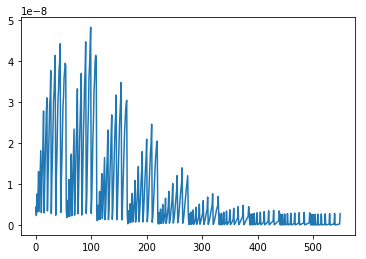

In [13]:
plt.plot(data["x_central"][0])

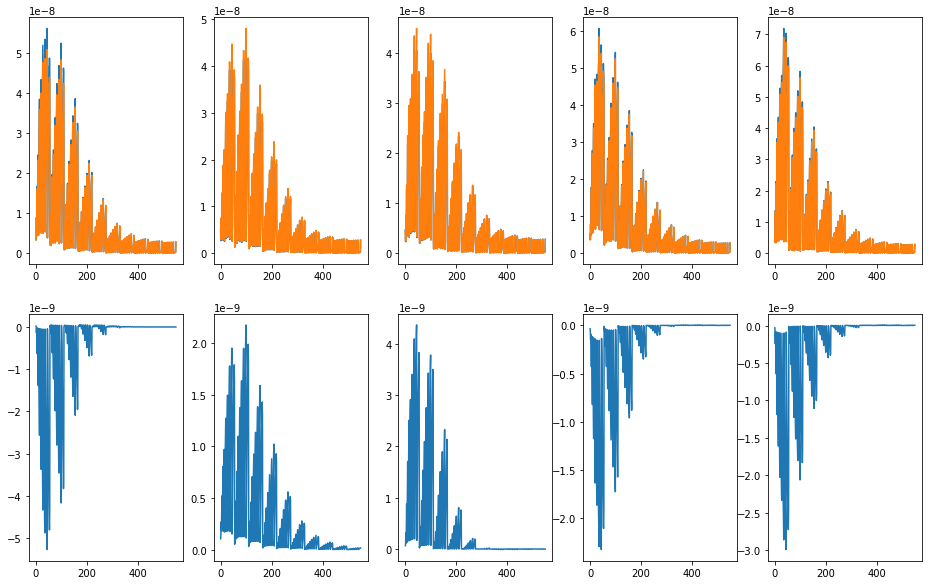

In [14]:
fig, ax = plt.subplots(2, 5, figsize = (16, 10))

for j in range(len(data["x_m"][0])):
    ax[0, j].plot(data["x_m"][1, j])
    ax[0, j].plot(data["x_p"][1, j])
    ax[1, j].plot(data["x_p"][1, j] - data["x_m"][1, j])

In [15]:
# Data vector
# Simulate some cosmic shear data
data = simulator(theta_fiducial, simulator_args)
compressed_data = compressor(data, compressor_args)
print("Fiducial parameter values = ", theta_fiducial)
print("IMNN MLE values = ", compressed_data)

Fiducial parameter values =  [0.3  0.8  0.05 0.7  0.96]
IMNN MLE values =  [0.3015547  0.74881196 0.03195877 0.7067726  0.9901111 ]


In [ ]:
# Create the DELFI MDN object
n_components = 3
mdn = nde.DelfiMixtureDensityNetwork(compressed_data, prior, [lower, upper], np.linalg.inv(n.sess.run(n.test_F)), theta_fiducial, n_components, n_hidden = [50, 50], activations = [tf.nn.tanh, tf.nn.tanh], names = names, labels = labels, ranges = ranges)

Pretraining data:   0%|          | 182/50000 [00:00<00:27, 1811.04it/s]

Generating pre-training data...


Epochs: 100%|██████████| 100/100 [05:58<00:00,  3.59s/it, loss=7.22, val_loss=7.28]


Done.
Sampling approximate posterior...
Done.
Saving fish_pretrain_post.pdf


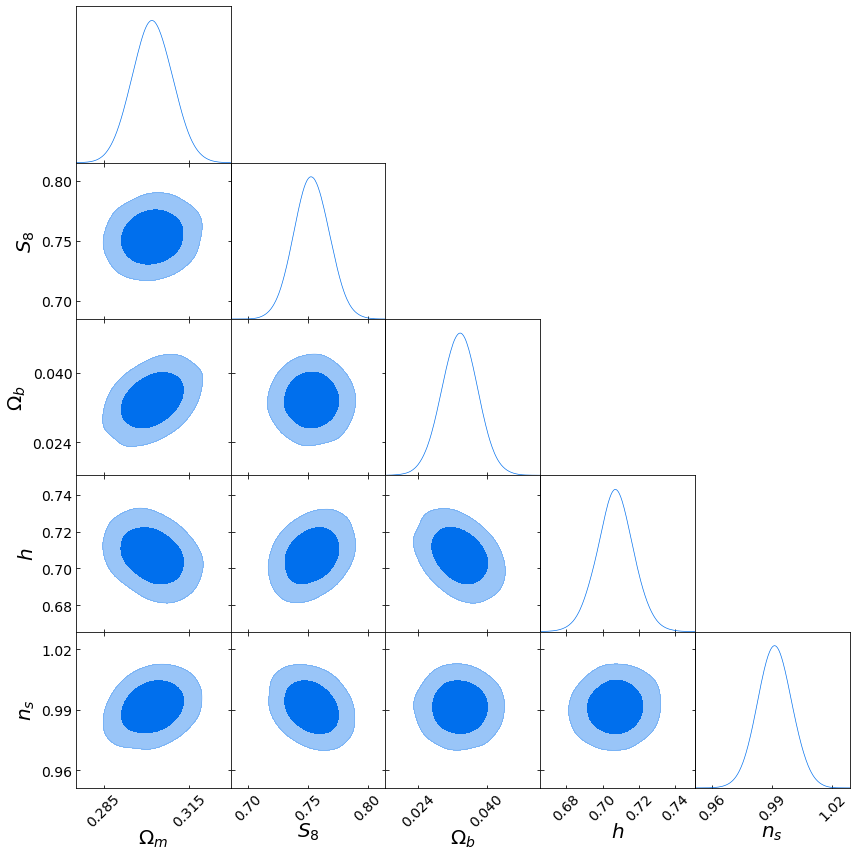

In [ ]:
# Do the Fisher pre-training
mdn.sess.run(tf.global_variables_initializer())
mdn.fisher_pretraining(50000, prior, epochs=100, epsilon = 1e-37)

  0%|          | 0/500 [00:00<?, ?it/s]

Running initial 500 sims...


Epochs:   3%|▎         | 3/100 [00:00<00:06, 15.27it/s, loss=10.5]               

Done.


Epochs: 100%|██████████| 100/100 [00:03<00:00, 25.06it/s, loss=4.77, val_loss=6.35]


Sampling approximate posterior...


/hdd/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/hdd/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)


Done.
Saving seq_train_post_0.pdf


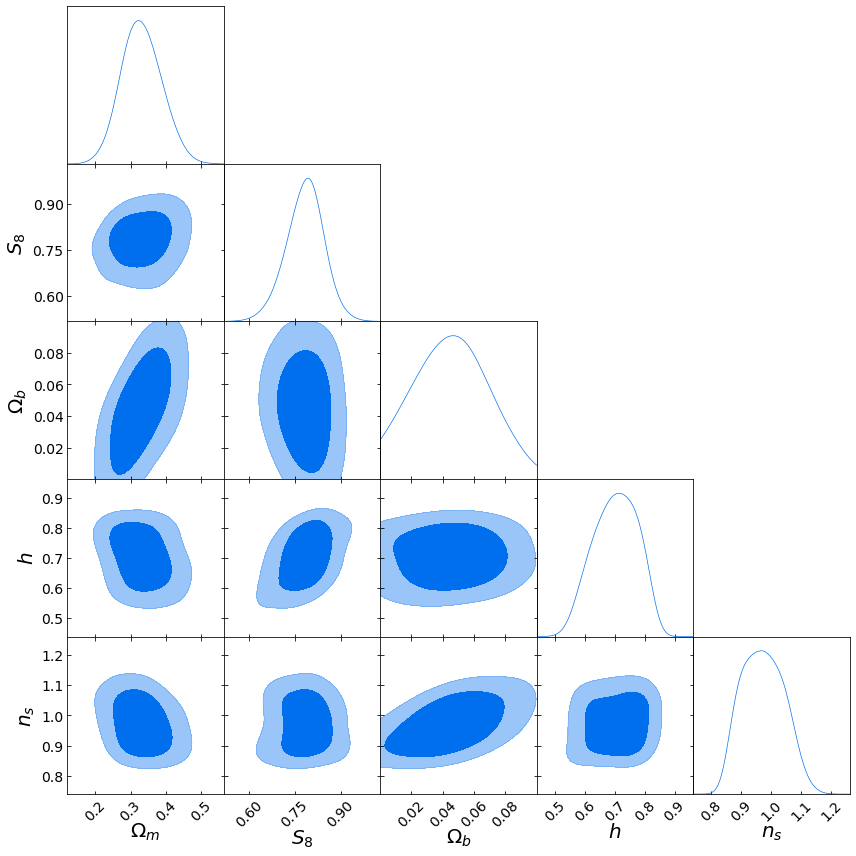

Population 1/15
Sampling proposal density...


/hdd/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/hdd/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


Epochs:   1%|          | 1/100 [00:00<00:19,  5.13it/s, loss=6.3]                

Done.


Epochs: 100%|██████████| 100/100 [00:07<00:00, 13.07it/s, loss=4.81, val_loss=5.2]


Sampling approximate posterior...
Done.
Saving seq_train_post_1.pdf


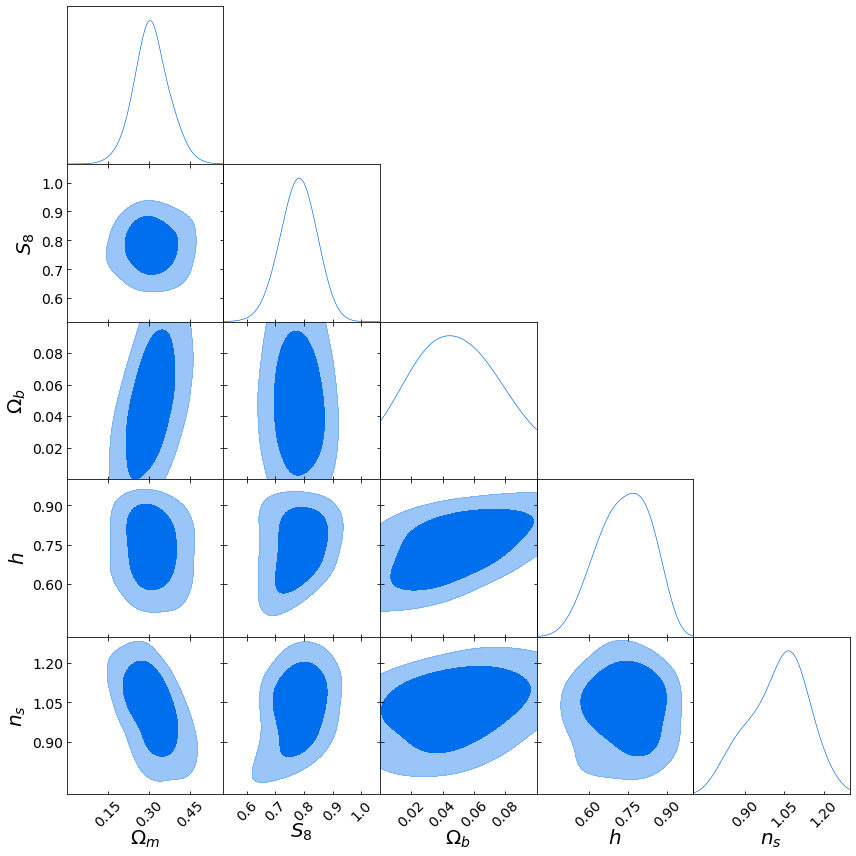

Population 2/15
Sampling proposal density...


/hdd/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/hdd/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


  4%|▍         | 19/500 [00:10<04:15,  1.88it/s]

Simulator returns exception for parameter values: [0.11430284 0.90051661 0.00240261 0.73701086 1.19929135] (rank 0)
Simulator returns exception for parameter values: [0.13045136 0.88855425 0.00634767 0.75143969 1.17406074] (rank 0)
Simulator returns exception for parameter values: [0.15768014 0.85743163 0.0096409  0.76855216 1.11449664] (rank 0)
Simulator returns exception for parameter values: [0.15768014 0.85743163 0.0096409  0.76855216 1.11449664] (rank 0)
Simulator returns exception for parameter values: [0.15768014 0.85743163 0.0096409  0.76855216 1.11449664] (rank 0)
Simulator returns exception for parameter values: [0.14510618 0.86392811 0.00694954 0.76415867 1.12729529] (rank 0)


  5%|▌         | 25/500 [00:14<04:36,  1.72it/s]

Simulator returns exception for parameter values: [0.1931926  0.90463055 0.04467968 0.85393848 1.08447328] (rank 0)
Simulator returns exception for parameter values: [0.1931926  0.90463055 0.04467968 0.85393848 1.08447328] (rank 0)


 92%|█████████▏| 461/500 [04:13<00:18,  2.07it/s]

Simulator returns exception for parameter values: [0.14722161 0.84089554 0.06549627 0.8705354  1.26075288] (rank 0)
Simulator returns exception for parameter values: [0.15394417 0.83708052 0.06585462 0.87171286 1.25091885] (rank 0)
Simulator returns exception for parameter values: [0.15394417 0.83708052 0.06585462 0.87171286 1.25091885] (rank 0)


Epochs:   1%|          | 1/100 [00:00<00:19,  5.20it/s, loss=5.37, val_loss=7.43]

Done.


Epochs: 100%|██████████| 100/100 [00:09<00:00, 10.38it/s, loss=4.25, val_loss=5.07]


Sampling approximate posterior...
Done.
Saving seq_train_post_2.pdf


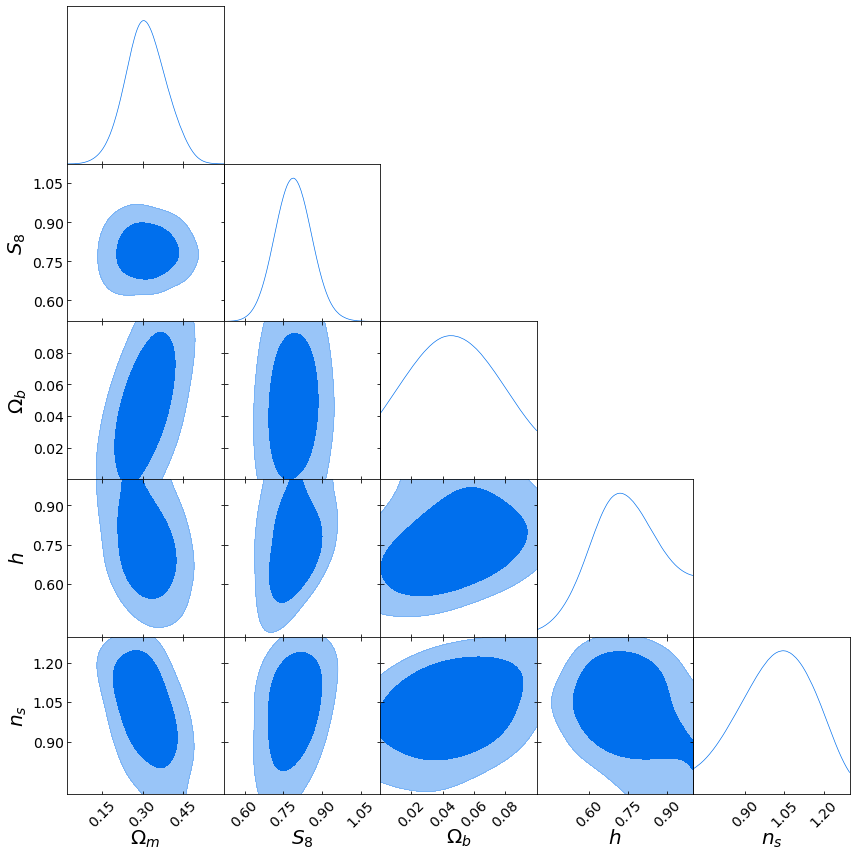

Population 3/15
Sampling proposal density...


/hdd/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/hdd/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


 21%|██        | 103/500 [00:46<03:14,  2.04it/s]

Simulator returns exception for parameter values: [0.08361977 0.71948505 0.00307681 0.95053388 1.12663695] (rank 0)
Simulator returns exception for parameter values: [0.08361977 0.71948505 0.00307681 0.95053388 1.12663695] (rank 0)
Simulator returns exception for parameter values: [0.08361977 0.71948505 0.00307681 0.95053388 1.12663695] (rank 0)
Simulator returns exception for parameter values: [0.08361977 0.71948505 0.00307681 0.95053388 1.12663695] (rank 0)
Simulator returns exception for parameter values: [0.08361977 0.71948505 0.00307681 0.95053388 1.12663695] (rank 0)
Simulator returns exception for parameter values: [0.12214184 0.7287412  0.0148345  0.90454482 1.13903926] (rank 0)
Simulator returns exception for parameter values: [0.11923746 0.72688823 0.01472081 0.90741867 1.14516427] (rank 0)
Simulator returns exception for parameter values: [0.11923746 0.72688823 0.01472081 0.90741867 1.14516427] (rank 0)


 95%|█████████▌| 476/500 [03:25<00:09,  2.49it/s]

Simulator returns exception for parameter values: [0.0717147  0.62874284 0.0275906  0.85710758 1.29382296] (rank 0)
Simulator returns exception for parameter values: [0.0717147  0.62874284 0.0275906  0.85710758 1.29382296] (rank 0)
Simulator returns exception for parameter values: [0.0717147  0.62874284 0.0275906  0.85710758 1.29382296] (rank 0)
Simulator returns exception for parameter values: [0.07935496 0.63170465 0.02688966 0.84830056 1.27757341] (rank 0)
Simulator returns exception for parameter values: [0.07935496 0.63170465 0.02688966 0.84830056 1.27757341] (rank 0)
Simulator returns exception for parameter values: [0.07935496 0.63170465 0.02688966 0.84830056 1.27757341] (rank 0)
Simulator returns exception for parameter values: [0.10482639 0.65039865 0.02639787 0.8258866  1.24538093] (rank 0)


Epochs:   1%|          | 1/100 [00:00<00:19,  5.17it/s, loss=4.9]                

Done.


Epochs: 100%|██████████| 100/100 [00:13<00:00,  7.32it/s, loss=4.32, val_loss=5.66]


Sampling approximate posterior...
Done.
Saving seq_train_post_3.pdf


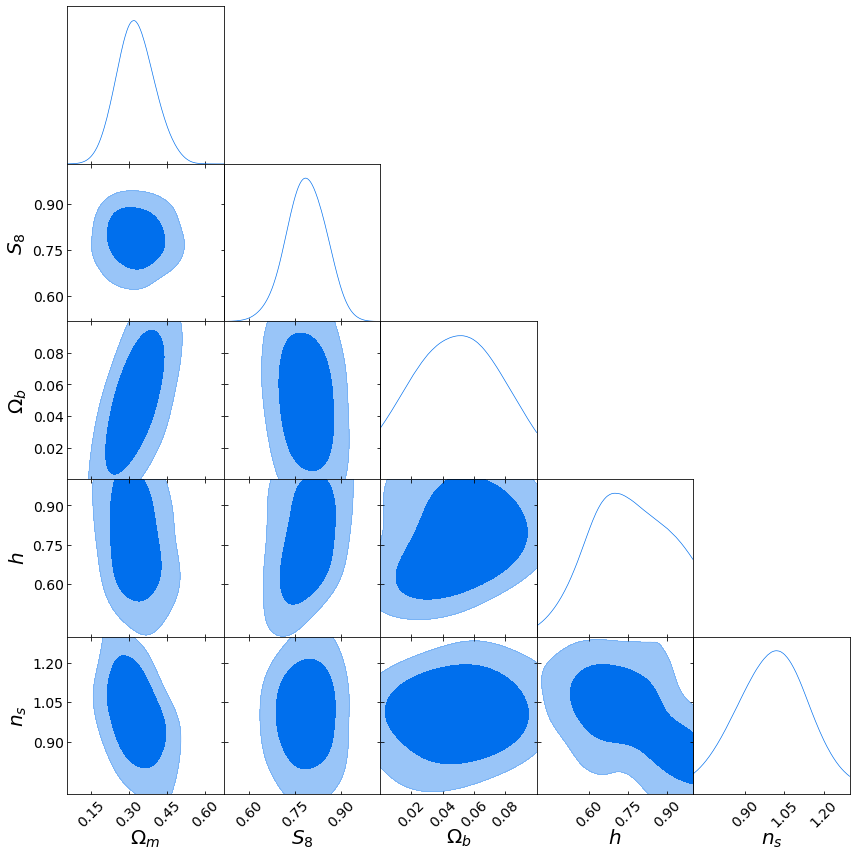

Population 4/15
Sampling proposal density...


/hdd/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/hdd/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


 49%|████▉     | 246/500 [01:43<01:44,  2.43it/s]

Simulator returns exception for parameter values: [0.12474194 0.73713695 0.04063146 0.94417798 1.10382875] (rank 0)
Simulator returns exception for parameter values: [0.12474194 0.73713695 0.04063146 0.94417798 1.10382875] (rank 0)
Simulator returns exception for parameter values: [0.13056284 0.74034009 0.0414688  0.94188438 1.10128543] (rank 0)
Simulator returns exception for parameter values: [0.13056284 0.74034009 0.0414688  0.94188438 1.10128543] (rank 0)
Simulator returns exception for parameter values: [0.12608144 0.73887088 0.04088941 0.94591643 1.10224649] (rank 0)


 50%|████▉     | 248/500 [01:45<02:19,  1.80it/s]

Simulator returns exception for parameter values: [0.13426246 0.75073699 0.03517405 0.94784084 1.10018914] (rank 0)
Simulator returns exception for parameter values: [0.13426246 0.75073699 0.03517405 0.94784084 1.10018914] (rank 0)
Simulator returns exception for parameter values: [0.13754367 0.75016709 0.03579474 0.94295543 1.09765458] (rank 0)
Simulator returns exception for parameter values: [0.13754367 0.75016709 0.03579474 0.94295543 1.09765458] (rank 0)


Epochs:   0%|          | 0/100 [00:00<?, ?it/s, loss=6.65]

Done.


Epochs: 100%|██████████| 100/100 [00:17<00:00,  5.59it/s, loss=4.66, val_loss=5.26]


Sampling approximate posterior...


In [ ]:
# Proposal for the SNL
proposal = priors.TruncatedGaussian(theta_fiducial, 9*np.linalg.inv(n.sess.run(n.test_F)), lower, upper)

# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 15

# Do the SNL training
mdn.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, proposal, epsilon = 1e-37, simulator_args=simulator_args, compressor_args=compressor_args)

In [ ]:
# Trace plot of the loss as a function of the number of simulations
plt.scatter(mdn.n_sim_trace, mdn.loss_trace, s = 20)
plt.plot(mdn.n_sim_trace, mdn.loss_trace, color = 'red')
plt.xlim(0, mdn.n_sim_trace[-1])
plt.xlabel('number of simulations')
plt.ylabel('loss')
plt.show()